In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from PIL import Image
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pandas as pd

In [2]:
# Load MNIST Dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

# Reshape Images to Match Model Input Shape (28x28x1)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

# Print Dataset Information
print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Train images shape: (60000, 28, 28, 1)
Test images shape: (10000, 28, 28, 1)


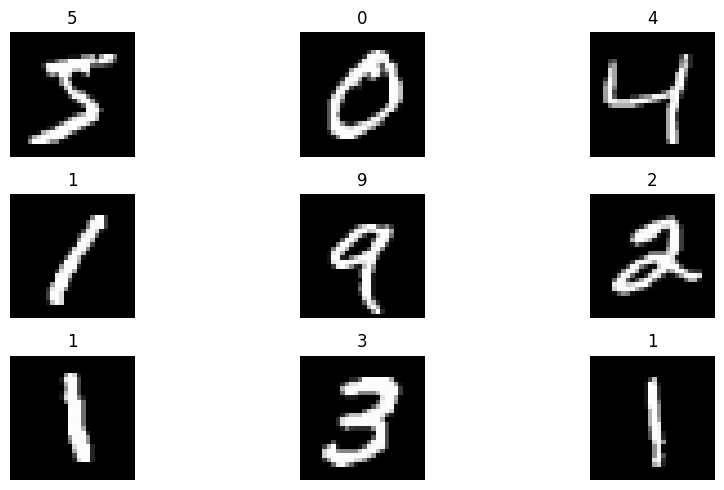

In [3]:
# Display Sample Images
fig, ax = plt.subplots(3, 3, figsize=(10, 5))
subset_index = np.arange(9)
subset_image = train_images[subset_index]
subset_label = train_labels[subset_index]
for i in range(3):
    for j in range(3):
        index = i * 3 + j
        ax[i][j].imshow(subset_image[index].reshape(28, 28), cmap='gray')
        ax[i][j].set_title(subset_label[index])
        ax[i][j].axis('off')
plt.tight_layout()
plt.show()

In [15]:
# Define Model-Building Function for Tuning
def build_model(hp):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), input_shape=(28, 28, 1), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('sigmoid'),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('sigmoid'),
        layers.AveragePooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('sigmoid'),

        layers.Flatten(),

        layers.Dense(64),
        layers.BatchNormalization(),
        layers.Activation('sigmoid'),

        layers.Dense(10, activation='softmax')
    ])
    # Tune Learning Rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [16]:
!pip install keras-tuner

In [17]:
import keras_tuner as kt

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='mnist_tuning_average_pooling'
)

tuner.search(train_images, train_labels, epochs=10, validation_split=0.2)

# Retrieve the Best Hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Retrieve and Evaluate the Best Model
best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_accuracy = best_model.evaluate(test_images, test_labels)
print(f"Best Test Accuracy: {test_accuracy}")
print(f"Best Test Loss: {test_loss}")

Reloading Tuner from my_dir/mnist_tuning_average_pooling/tuner0.json
Best Hyperparameters: {'learning_rate': 0.01}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9861 - loss: 0.0524
Best Test Accuracy: 0.9879999756813049
Best Test Loss: 0.044907744973897934


In [18]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert('L')
    img.thumbnail((20, 20))
    new_img = Image.new('L', (28, 28), 255)
    img_w, img_h = img.size
    offset = ((28 - img_w) // 2, (28 - img_h) // 2)
    new_img.paste(img, offset)
    img_array = np.array(new_img)
    img_array = 255 - img_array  # Invert the image
    img_array = img_array / 255.0  # Normalize
    img_array = img_array.reshape(1, 28, 28, 1)
    return img_array

In [19]:
def visualize_image(image_array):
    img_to_show = image_array.reshape(28, 28)
    plt.imshow(img_to_show, cmap='gray')
    plt.show()

# Predict the Digit
def predict_digit(preprocessed_image):
    prediction = best_model.predict(preprocessed_image)
    print(f'Prediction probabilities: {prediction}')
    predicted_digit = np.argmax(prediction)
    return predicted_digit

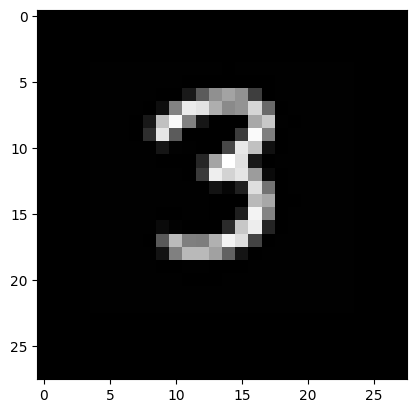

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
Prediction probabilities: [[1.0876998e-12 4.0747398e-08 2.1367343e-07 9.9871826e-01 2.5408597e-10
  3.6594093e-07 3.2187055e-14 2.8324239e-06 6.3846613e-07 1.2777101e-03]]
Predicted digit: 3


In [20]:
# Input Path of Image
image_path = r"digit3.jpeg"  # Update the path to your image

# Preprocess and Visualize the Image
preprocessed_image = preprocess_image(image_path)
visualize_image(preprocessed_image)

# Predict and Display the Result
predicted_digit = predict_digit(preprocessed_image)
print(f'Predicted digit: {predicted_digit}')

In [21]:
import numpy as np

# Predict the probabilities for the test set
predictions = best_model.predict(test_images)

# Get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Separate predictions for digits 7 and 8
seven_indices = np.where(test_labels == 7)[0]
eight_indices = np.where(test_labels == 8)[0]


seven_correct = np.sum(predicted_labels[seven_indices] == test_labels[seven_indices])
eight_correct = np.sum(predicted_labels[eight_indices] == test_labels[eight_indices])

seven_accuracy = seven_correct / len(seven_indices) if len(seven_indices) > 0 else 0
eight_accuracy = eight_correct / len(eight_indices) if len(eight_indices) > 0 else 0

print(f"Accuracy for digit 7: {seven_accuracy}")
print(f"Accuracy for digit 8: {eight_accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy for digit 7: 0.9990272373540856
Accuracy for digit 8: 0.9928131416837782


In [22]:
#Extracting summary metrics (e.g., accuracy, precision, recall, F1 score) table.

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='weighted') # Use 'weighted' for multi-class
recall = recall_score(test_labels, predicted_labels, average='weighted')
f1 = f1_score(test_labels, predicted_labels, average='weighted')

metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
}
metrics_df = pd.DataFrame(metrics)
metrics_df

,Metric,Value
0,Accuracy,0.988000
1,Precision,0.988199
2,Recall,0.988000
3,F1 Score,0.988027


Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9936 - loss: 0.0181 - val_accuracy: 0.9793 - val_loss: 0.0880
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.9946 - loss: 0.0159 - val_accuracy: 0.8374 - val_loss: 0.6500
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9948 - loss: 0.0154 - val_accuracy: 0.9817 - val_loss: 0.0844
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9962 - loss: 0.0113 - val_accuracy: 0.9863 - val_loss: 0.0606
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9962 - loss: 0.0117 - val_accuracy: 0.9821 - val_loss: 0.0762
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9963 - loss: 0.0115 - val_accuracy: 0.9843 - val_loss: 0.0677
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9967 - loss: 0.0107 - val_accuracy: 0.9835 - val_loss: 0.0741
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9960 - loss: 0.010

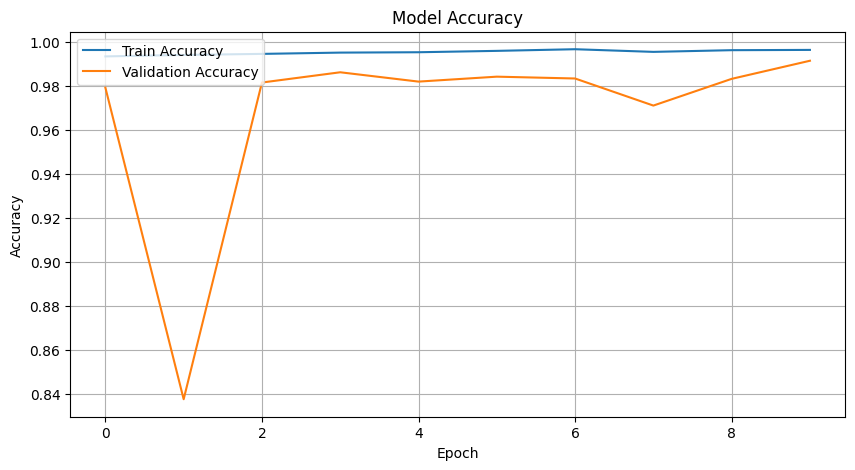

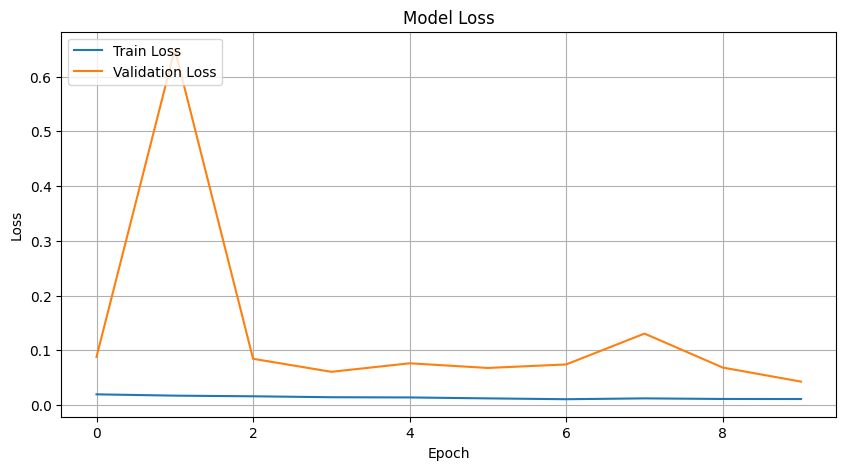

In [23]:
# Fit the model and capture the history
history = best_model.fit(train_images, train_labels, validation_split=0.2, epochs=10)

# Get the training history
history_data = history.history

# Plot training accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history_data.get('accuracy', []), label='Train Accuracy')
plt.plot(history_data.get('val_accuracy', []), label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()
plt.show()

# Plot training loss values
plt.figure(figsize=(10, 5))
plt.plot(history_data.get('loss', []), label='Train Loss')
plt.plot(history_data.get('val_loss', []), label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid()
plt.show()

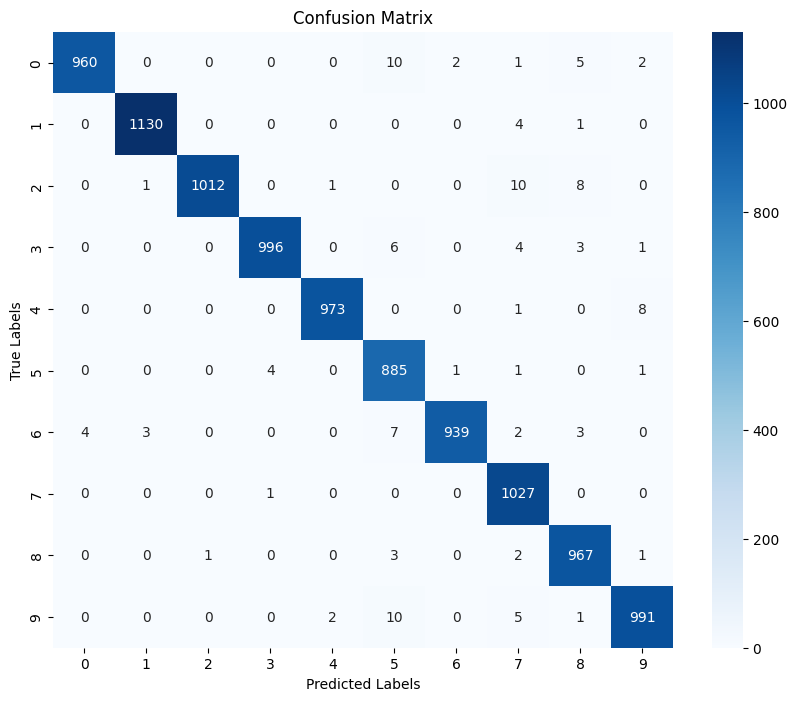

In [24]:
#Displaying the confusion matrix as a heatmap.

# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()